## Uniform Time Course process output comparisons

In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')

In [2]:
from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs, plot_ode_output_data

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'utc-tellurium',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d',
  'utc-comparator']


In [3]:
from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

In [4]:
omex_dir = '../test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [5]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

In [6]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(400.0, 1000.0, 1000, 1.0, 601)

In [7]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

cat: ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml: No such file or directory


In [8]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

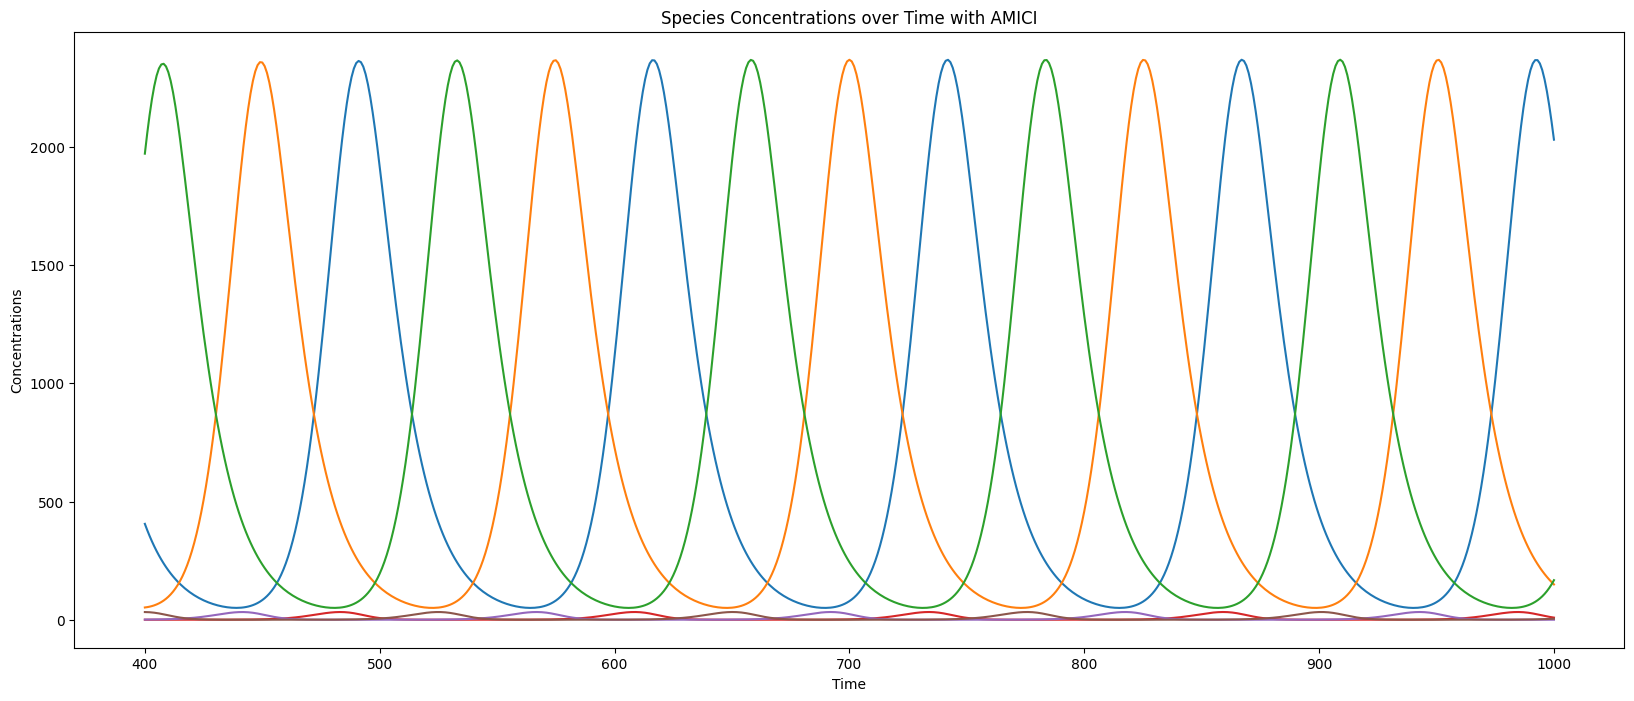

In [9]:
# use built-in plot to plot results
utc_amici.plot_results()

Create a `UtcTellurium` instance as above

In [10]:
from biosimulator_processes.processes.tellurium_process import UtcTellurium


utc_tellurium = UtcTellurium(config={'model': {'model_source': omex_dir + '.omex'}})

In [11]:
tellurium_results = utc_tellurium.update()

In [12]:
utc_tellurium._results['floating_species'].keys()

dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])

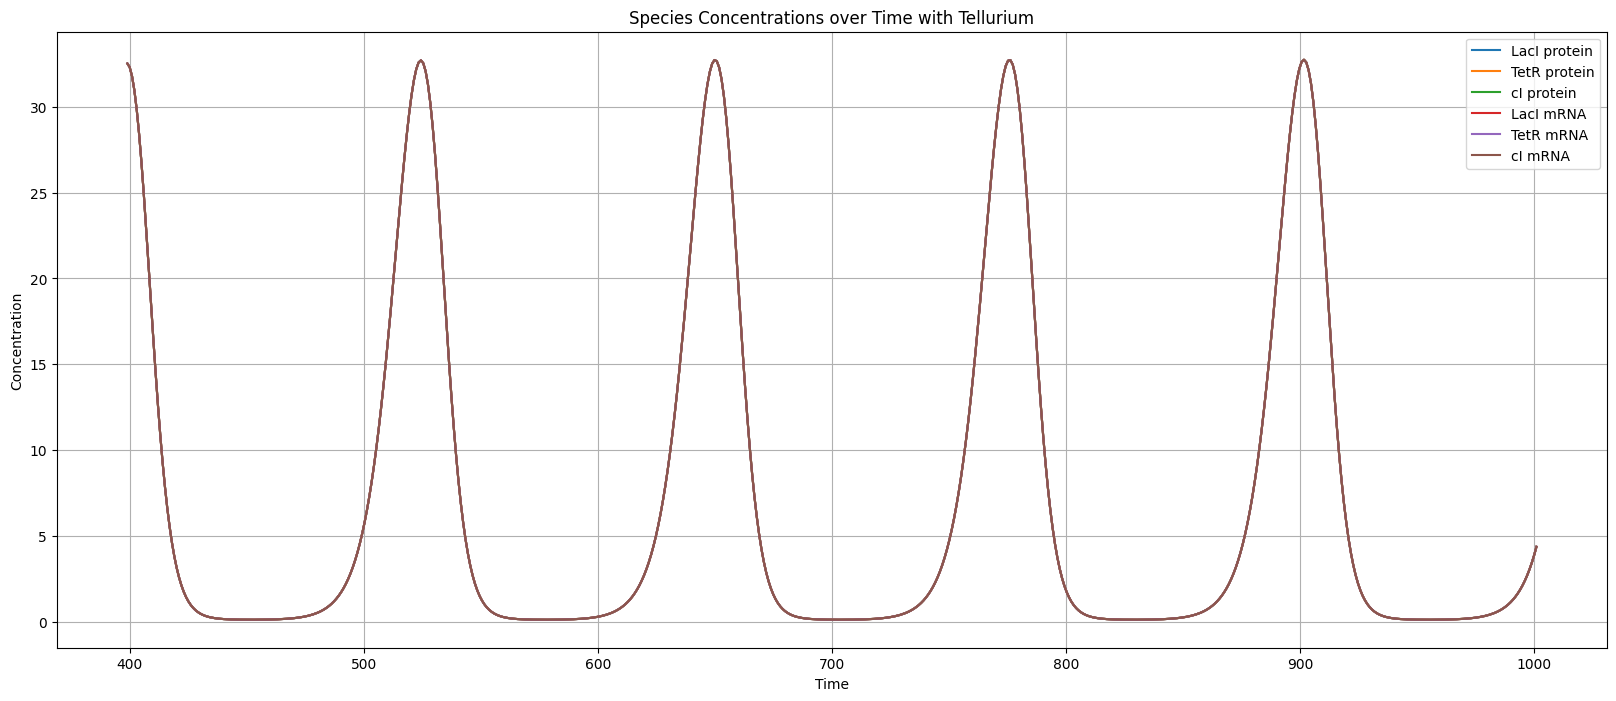

In [13]:
utc_tellurium.plot_results()

Create a `UtcCopasi` instance and run the same

In [14]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [15]:
copasi_results = utc_copasi.update()

In [16]:
copasi_results['time'][-1]

1000.0

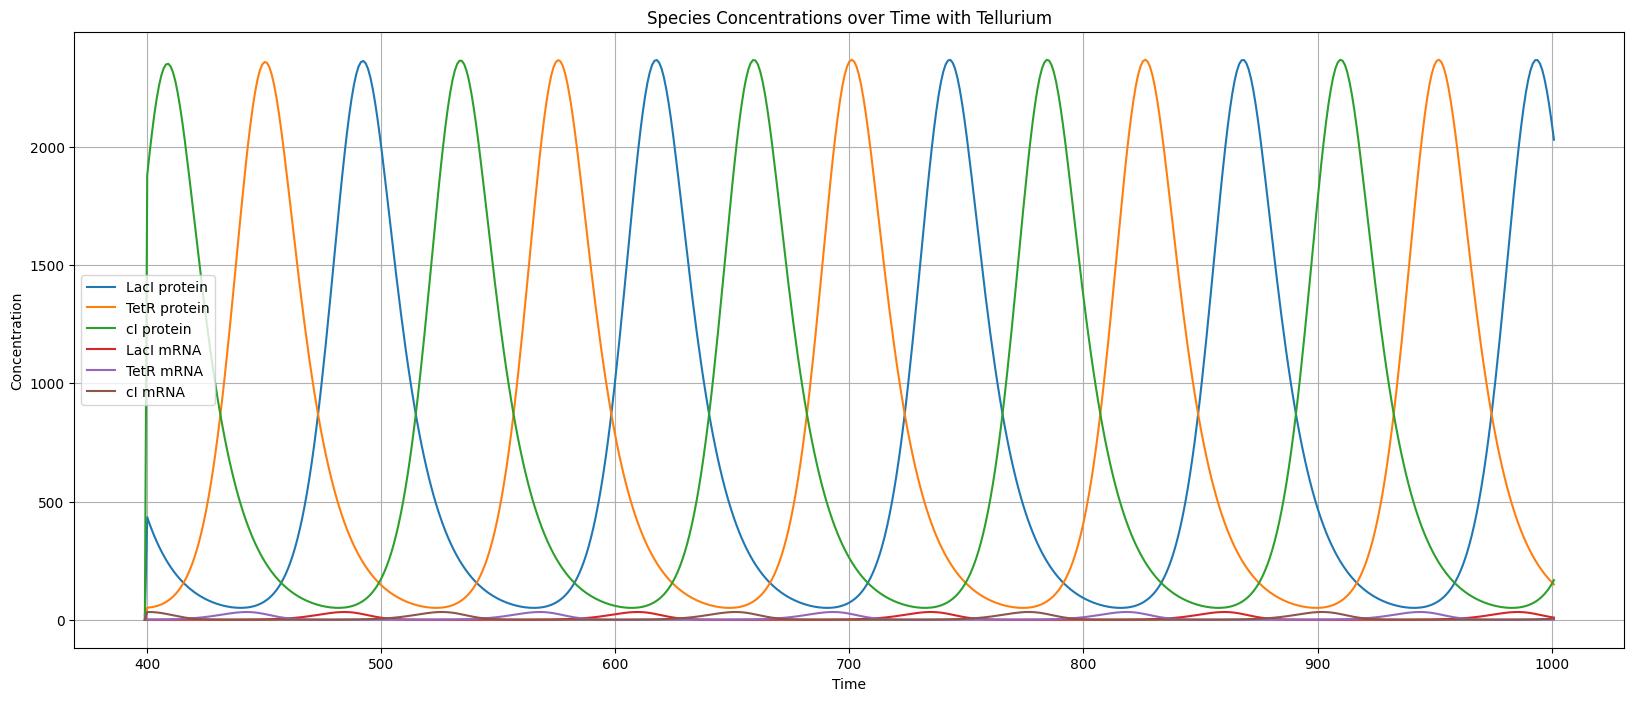

In [17]:
utc_copasi.plot_results()

In [18]:
utc_copasi._tc

,LacI protein,TetR protein,cI protein,LacI mRNA,TetR mRNA,cI mRNA,Time
0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
1,433.590028,50.944920,1879.403192,0.154434,0.614397,32.452362,399.000000
2,405.466046,51.899563,1971.566904,0.145426,0.689483,32.523645,400.003339
3,379.176989,53.329869,2057.023621,0.138122,0.775195,32.299961,401.006678
4,354.609912,55.280078,2134.200901,0.132205,0.872976,31.770469,402.010017
...,...,...,...,...,...,...,...
596,2286.340383,193.630030,108.992960,16.316244,0.112850,2.675559,995.986644
597,2235.414919,181.380152,120.815001,14.291386,0.113081,3.026563,996.989983
598,2174.707210,169.955979,134.348049,12.389764,0.113657,3.421586,997.993322
599,2105.804178,159.304360,149.788220,10.639530,0.114581,3.865178,998.996661


Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [19]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import write_utc_comparison_reports
from biosimulator_processes.io import standardize_report_outputs

In [20]:
report_results = standardize_report_outputs(reports_path)

In [21]:
print(f"copasi result keys: {copasi_results['floating_species'].keys()}\nTellurium result keys: {tellurium_results['floating_species'].keys()}\nAmici Result keys: {amici_results['floating_species'].keys()}\nGround truth report keys: {report_results['floating_species'].keys()}")

copasi result keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])
Tellurium result keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])
Amici Result keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])
Ground truth report keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])


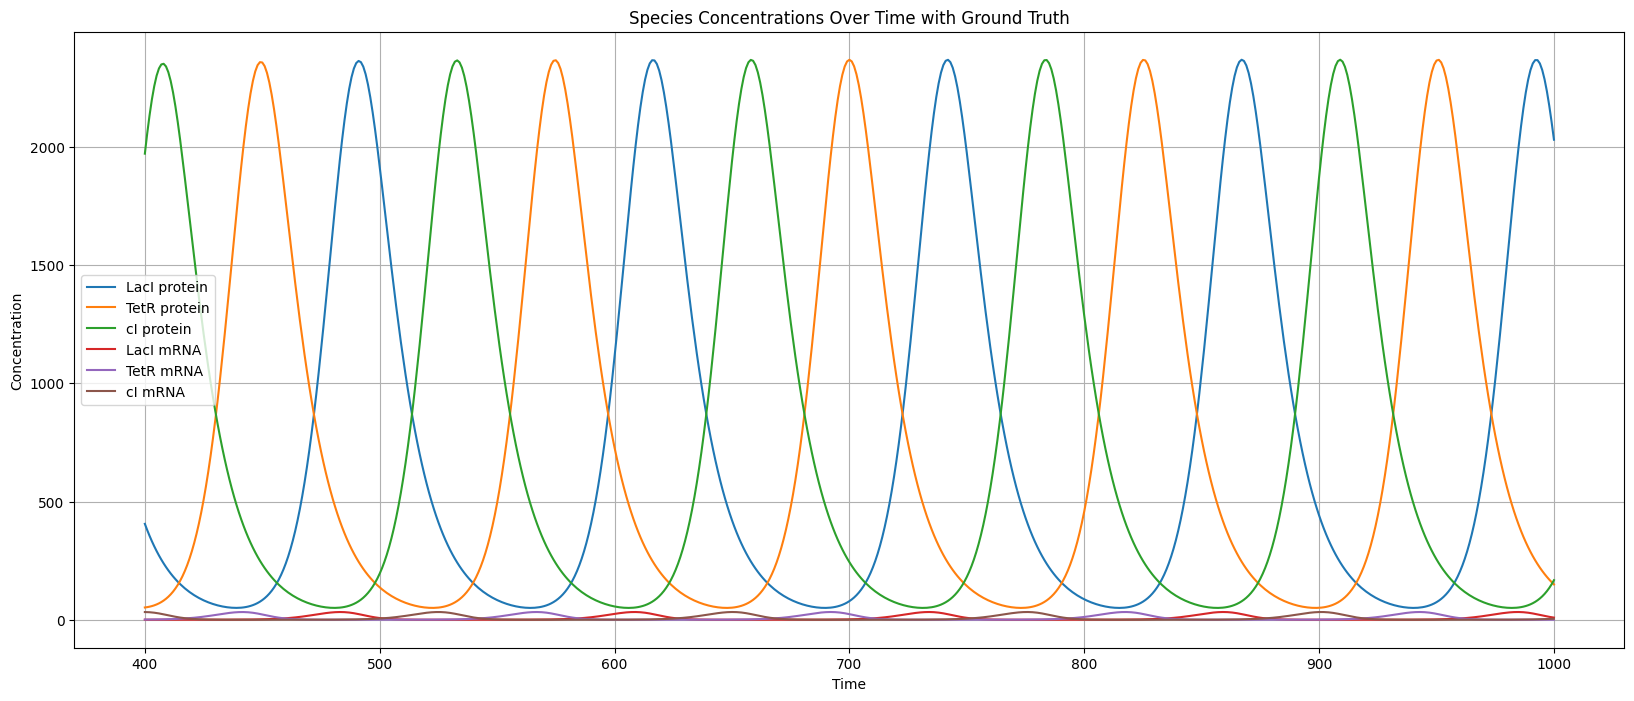

In [22]:
plot_ode_output_data(report_results, simulator_name='Ground Truth')

Generate a series of comparisons for each species and save to a given dir

In [23]:
utc_copasi.t[-1]

1000.0

In [24]:
utc_copasi.step_size, utc_amici.step_size, utc_tellurium.step_size

(1.0, 1.0, 1.0)

In [25]:
save_dir = '../test_outputs/repressilator-utc-comparison'
if os.path.exists(save_dir):
    import shutil 
    shutil.rmtree(save_dir)
    
    
write_utc_comparison_reports(
    save_dir=save_dir,
    copasi_results=copasi_results,
    tellurium_results=tellurium_results,
    amici_results=amici_results,
    ground_truth_results=report_results,
    sbml_species_mapping=utc_copasi.sbml_species_mapping,
    method='prox')

In [26]:
utc_amici.floating_species_list, amici_results.get('floating_species').keys()

(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'],
 dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA']))

In [27]:
[spec.name for spec in utc_copasi.sbml_model.getListOfSpecies()]

['LacI protein',
 'TetR protein',
 'cI protein',
 'LacI mRNA',
 'TetR mRNA',
 'cI mRNA']

In [28]:
utc_copasi.floating_species_list

['PX', 'PY', 'PZ', 'X', 'Y', 'Z']

In [29]:
utc_tellurium.floating_species_list

['PX', 'PY', 'PZ', 'X', 'Y', 'Z']

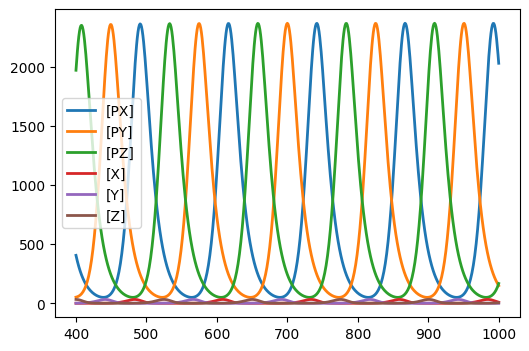

In [30]:
utc_tellurium.simulator.plot()

<Axes: >

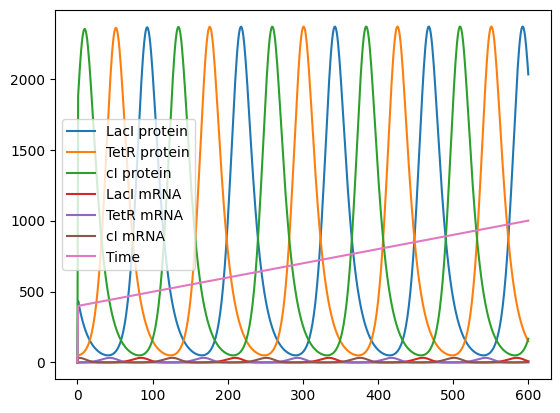

In [31]:
utc_copasi._tc.plot()

In [32]:
from notebook_api.utc import generate_utc_step_outputs

In [33]:
results = generate_utc_step_outputs(omex_fp)

from process_bigraph import pp


pp(results)

2024-05-31 19:28:53.994 - amici.sbml_import - INFO - Finished loading SBML                           (6.50E-03s)
2024-05-31 19:28:54.039 - amici.sbml_import - INFO - Finished importing SBML                         (4.06E-02s)
2024-05-31 19:28:54.057 - amici.sbml_import - INFO - Finished processing SBML observables            (1.34E-02s)
2024-05-31 19:28:54.061 - amici.sbml_import - INFO - Finished processing SBML event observables      (5.41E-07s)
2024-05-31 19:28:54.084 - amici.de_model - INFO - Finished computing xdot                            (3.31E-03s)
2024-05-31 19:28:54.090 - amici.de_model - INFO - Finished computing x0                              (2.93E-03s)
2024-05-31 19:28:54.102 - amici.de_model - INFO - Finished computing w                               (7.79E-03s)
2024-05-31 19:28:54.738 - amici.de_export - INFO - Finished generating cpp code                      (6.32E-01s)
2024-05-31 19:29:02.244 - amici.de_export - INFO - Finished compiling cpp code                  

{ 'instances': [ <biosimulator_processes.processes.amici_process.UtcAmici object at 0x1777d02d0>,
  'results': { 'amici': { 'floating_species': { 'LacI mRNA': array([ 0.14545264,  0.13816602,  0.13225852,  0.12747995,  0.12363243,
        0.12056001,  0.11814058,  0.11627933,  0.11490374,  0.11395958,
        0.11340783,  0.1132224 ,  0.11338834,  0.11390059,  0.11476316,
        0.11598863,  0.1175979 ,  0.11962029,  0.12209376,  0.12506548,
        0.12859243,  0.13274242,  0.13759512,  0.14324347,  0.14979527,
        0.15737502,  0.16612611,  0.17621331,  0.18782561,  0.20117952,
        0.21652275,  0.23413848,  0.25435012,  0.27752674,  0.30408918,
        0.33451693,  0.36935578,  0.40922648,  0.4548343 ,  0.50697964,
        0.56656976,  0.63463162,  0.71232593,  0.80096231,  0.90201546,
        1.01714243,  1.14820055,  1.29726571,  1.46665075,  1.65892305,
        1.87692063,  2.12376562,  2.40287365,  2.7179573 ,  3.0730216 ,
        3.47234872,  3.92046889,  4.42211413,  4.

In [34]:
results['results']['amici']['floating_species'].keys()

dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])

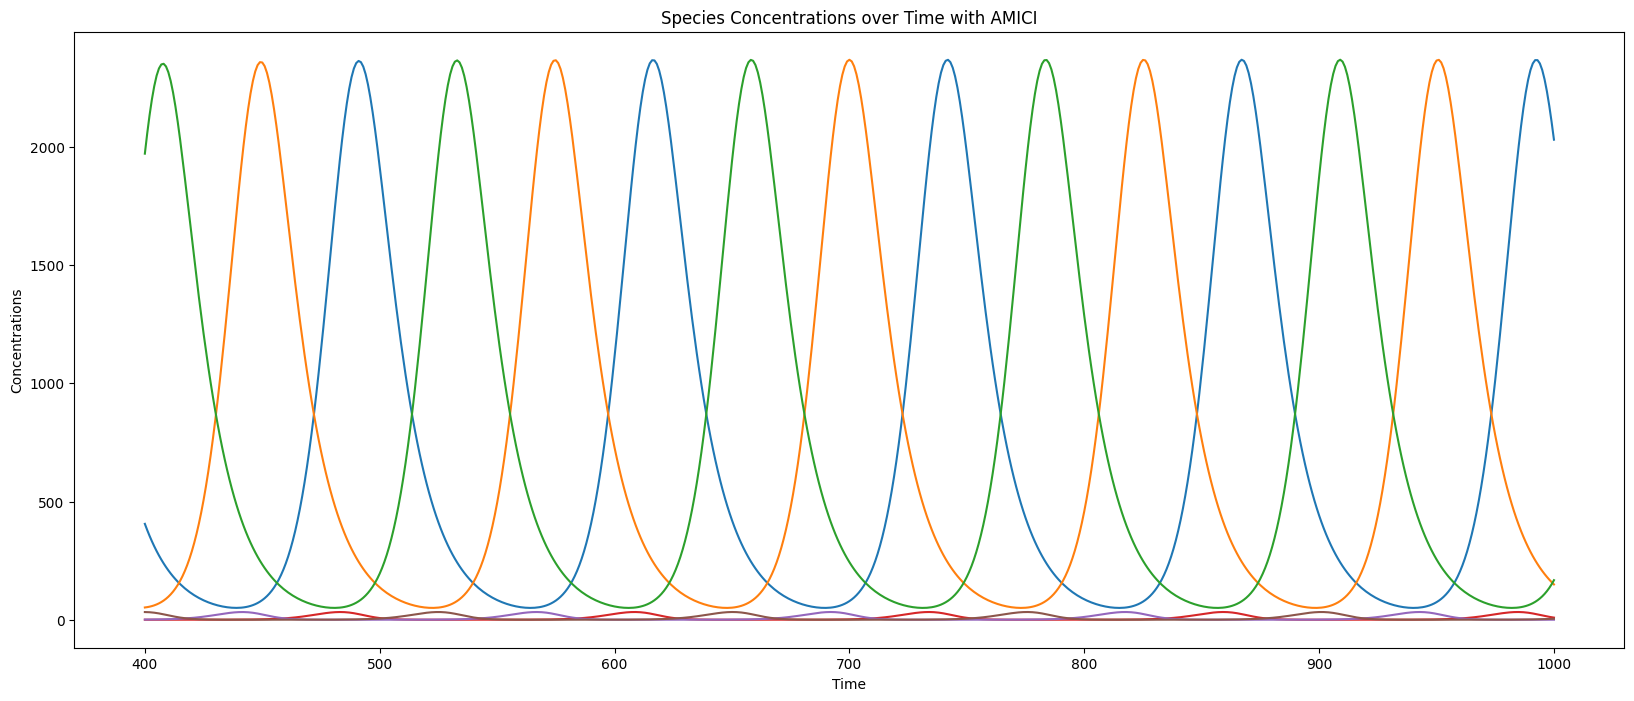

In [40]:
results['instances'][0].plot_results()

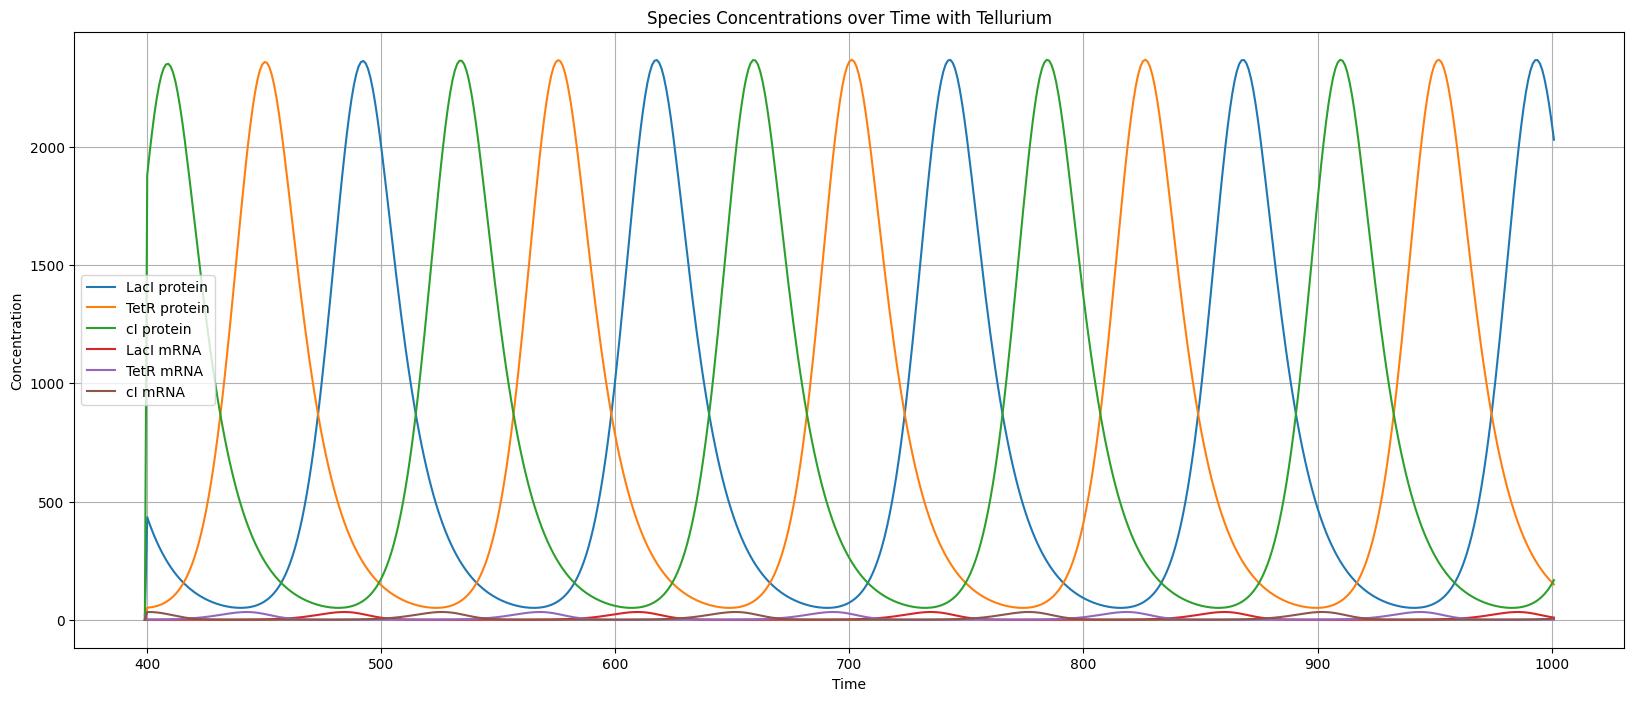

In [35]:
results['instances'][1].plot_results()

We can read the data from any of the saved files:

In [36]:
csv_result_dir = list(map(lambda d: os.path.join(save_dir, d), os.listdir(save_dir)))

csv_result_dir

['../test_outputs/repressilator-utc-comparison/LacI_protein_comparison.csv',
 '../test_outputs/repressilator-utc-comparison/cI_protein_comparison.csv',
 '../test_outputs/repressilator-utc-comparison/TetR_mRNA_comparison.csv',
 '../test_outputs/repressilator-utc-comparison/LacI_mRNA_comparison.csv',
 '../test_outputs/repressilator-utc-comparison/cI_mRNA_comparison.csv',
 '../test_outputs/repressilator-utc-comparison/TetR_protein_comparison.csv']

In [37]:
import pandas as pd 

dfs = list(map(pd.read_csv, csv_result_dir))

In [38]:
lac_ci_df = pd.read_csv(csv_result_dir[0])

In [39]:
lac_ci_df

,Unnamed: 0,copasi,amici,tellurium,ground_truth
0,copasi,True,False,False,False
1,amici,False,True,False,True
2,tellurium,False,False,True,False
3,ground_truth,False,True,False,True


In [5]:
from process_bigraph import Composite


doc = {
    'amici': {
        '_type': 'step',
        'address': 'local:utc-amici',
        'config': {
            'model': {
                'model_source': omex_fp
            }
        },
        'inputs': {
            'time': ['time_store'],
            'floating_species': ['amici_floating_species_store'],
            'model_parameters': ['amici_model_parameters_store'],
            'reactions': ['amici_reactions_store']
        },
        'outputs': {
            'time': ['time_store'],
            'floating_species': ['amici_floating_species_store']
        }
    },
    'copasi': {
        '_type': 'step',
        'address': 'local:utc-copasi',
        'config': {
            'model': {
                'model_source': omex_fp
            }
        },
        'inputs': {
            'time': ['time_store'],
            'floating_species': ['copasi_floating_species_store'],
            'model_parameters': ['copasi_model_parameters_store'],
            'reactions': ['copasi_reactions_store']
        },
        'outputs': {
            'time': ['time_store'],
            'floating_species': ['copasi_floating_species_store']
        }
    },
    'tellurium': {
        '_type': 'step',
        'address': 'local:utc-tellurium',
        'config': {
            'model': {
                'model_source': omex_fp
            }
        },
        'inputs': {
            'time': ['time_store'],
            'floating_species': ['tellurium_floating_species_store'],
            'model_parameters': ['tellurium_model_parameters_store'],
            'reactions': ['tellurium_reactions_store']
        },
        'outputs': {
            'time': ['time_store'],
            'floating_species': ['tellurium_floating_species_store']
        }
    },
    'comparison': {
        '_type': 'step',
        'address': 'local:utc-comparator',
        'config': {
            'simulators': ['amici', 'copasi', 'tellurium'],
        },
        'inputs': {
            'time': ['time_store'],
            'amici_floating_species': ['amici_floating_species_store'],
            'copasi_floating_species': ['copasi_floating_species_store'],
            'tellurium_floating_species': ['tellurium_floating_species_store'],
        },
        'outputs': {
            'mean_squared_error': ['mean_squared_error_store'],
            'proximity': ['proximity_store'],
            'output_data': ['output_data_store']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'mean_squared_error': 'tree[string]',
                'proximity': 'tree[string]',
                'output_data': 'tree[string]'
            }
        },
        'inputs': {
            'mean_squared_error': ['mean_squared_error_store'],
            'proximity': ['proximity_store'],
            'output_data': ['output_data_store']
        }
    }
}

2024-06-04 21:33:43.660 - amici.sbml_import - INFO - Finished importing SBML                         (7.87E-02s)
2024-06-04 21:33:43.753 - amici.sbml_import - INFO - Finished processing SBML observables            (8.73E-02s)
2024-06-04 21:33:43.759 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.21E-06s)
2024-06-04 21:33:43.803 - amici.de_model - INFO - Finished computing xdot                            (6.05E-03s)
2024-06-04 21:33:43.815 - amici.de_model - INFO - Finished computing x0                              (4.96E-03s)
2024-06-04 21:33:43.852 - amici.de_model - INFO - Finished computing w                               (3.07E-02s)
2024-06-04 21:33:45.351 - amici.de_export - INFO - Finished generating cpp code                      (1.49E+00s)
2024-06-04 21:34:02.977 - amici.de_export - INFO - Finished compiling cpp code                       (1.76E+01s)


In [7]:
result = wf.run(1)

In [8]:
result = wf.gather_results()

In [9]:
result

{('emitter',): []}